# 1. 필수 파일 설치 및 파일 경로 설정


In [ ]:
# 1. 필수 라이브러리 및 NumPy 버전 호환성 설정
!pip install -q timm albumentations facenet-pytorch
!pip install numpy matplotlib opencv-python
!pip install "numpy<2.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 111.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 135.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.1

In [ ]:
# 2. 프로젝트 폴더 구조 생성
import os
os.makedirs('config', exist_ok=True)
os.makedirs('src', exist_ok=True)
os.makedirs('model', exist_ok=True)
os.makedirs('data', exist_ok=True)       # 대회(Target) 데이터용
os.makedirs('data_ffpp', exist_ok=True)  # FF++(Source) 데이터용
os.makedirs('test_data', exist_ok=True)

print("✅ 환경 설정 및 폴더 생성 완료!")

✅ 환경 설정 및 폴더 생성 완료!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# 마운트 반드시 해주기.

Mounted at /content/drive


In [ ]:
%%writefile download.py
# -*- coding: utf-8 -*-
""" Downloads FaceForensics++ and Deep Fake Detection public data release """
import argparse
import os
import urllib
import urllib.request
import tempfile
import time
import sys
import json
import random
from tqdm import tqdm
from os.path import join

# URLs and filenames
FILELIST_URL = 'misc/filelist.json'
DEEPFEAKES_DETECTION_URL = 'misc/deepfake_detection_filenames.json'
DEEPFAKES_MODEL_NAMES = ['decoder_A.h5', 'decoder_B.h5', 'encoder.h5',]

# Parameters
DATASETS = {
    'original_youtube_videos': 'misc/downloaded_youtube_videos.zip',
    'original_youtube_videos_info': 'misc/downloaded_youtube_videos_info.zip',
    'original': 'original_sequences/youtube',
    'DeepFakeDetection_original': 'original_sequences/actors',
    'Deepfakes': 'manipulated_sequences/Deepfakes',
    'DeepFakeDetection': 'manipulated_sequences/DeepFakeDetection',
    'Face2Face': 'manipulated_sequences/Face2Face',
    'FaceShifter': 'manipulated_sequences/FaceShifter',
    'FaceSwap': 'manipulated_sequences/FaceSwap',
    'NeuralTextures': 'manipulated_sequences/NeuralTextures'
    }
ALL_DATASETS = ['original', 'DeepFakeDetection_original', 'Deepfakes',
                'DeepFakeDetection', 'Face2Face', 'FaceShifter', 'FaceSwap',
                'NeuralTextures']
COMPRESSION = ['raw', 'c23', 'c40']
TYPE = ['videos', 'masks', 'models']
SERVERS = ['EU', 'EU2', 'CA']


def parse_args():
    parser = argparse.ArgumentParser(
        description='Downloads FaceForensics v2 public data release.',
        formatter_class=argparse.ArgumentDefaultsHelpFormatter
    )
    parser.add_argument('output_path', type=str, help='Output directory.')
    parser.add_argument('-d', '--dataset', type=str, default='all',
                        help='Which dataset to download',
                        choices=list(DATASETS.keys()) + ['all']
                        )
    parser.add_argument('-c', '--compression', type=str, default='raw',
                        help='Which compression degree.',
                        choices=COMPRESSION
                        )
    parser.add_argument('-t', '--type', type=str, default='videos',
                        help='Which file type',
                        choices=TYPE
                        )
    parser.add_argument('-n', '--num_videos', type=int, default=None,
                        help='Select a number of videos number to download')
    parser.add_argument('--server', type=str, default='EU',
                        help='Server to download the data from.',
                        choices=SERVERS
                        )
    args = parser.parse_args()

    # URLs
    server = args.server
    if server == 'EU':
        server_url = 'http://canis.vc.in.tum.de:8100/'
    elif server == 'EU2':
        server_url = 'http://kaldir.vc.in.tum.de/faceforensics/'
    elif server == 'CA':
        server_url = 'http://falas.cmpt.sfu.ca:8100/'
    else:
        raise Exception('Wrong server name. Choices: {}'.format(str(SERVERS)))
    args.tos_url = server_url + 'webpage/FaceForensics_TOS.pdf'
    args.base_url = server_url + 'v3/'
    args.deepfakes_model_url = server_url + 'v3/manipulated_sequences/' + \
                               'Deepfakes/models/'

    return args


def download_files(filenames, base_url, output_path, report_progress=True):
    os.makedirs(output_path, exist_ok=True)
    if report_progress:
        filenames = tqdm(filenames)
    for filename in filenames:
        download_file(base_url + filename, join(output_path, filename))


def reporthook(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    if duration > 0:
        speed = int(progress_size / (1024 * duration))
    else:
        speed = 0
    if total_size > 0:
        percent = int(count * block_size * 100 / total_size)
    else:
        percent = 0
    sys.stdout.write("\rProgress: %d%%, %d MB, %d KB/s, %d seconds passed" %
                     (percent, progress_size / (1024 * 1024), speed, duration))
    sys.stdout.flush()


def download_file(url, out_file, report_progress=False):
    out_dir = os.path.dirname(out_file)
    if not os.path.isfile(out_file):
        fh, out_file_tmp = tempfile.mkstemp(dir=out_dir)
        f = os.fdopen(fh, 'w')
        f.close()
        try:
            if report_progress:
                urllib.request.urlretrieve(url, out_file_tmp,
                                           reporthook=reporthook)
            else:
                urllib.request.urlretrieve(url, out_file_tmp)
            os.rename(out_file_tmp, out_file)
        except Exception as e:
            print(f"\nError downloading {url}: {e}")
            os.remove(out_file_tmp)
    else:
        # [수정] 이미 파일이 있으면 아무 메시지도 출력하지 않고 조용히 넘어감
        pass


def main(args):
    # TOS
    print('By running this script you confirm that you have agreed '\
          'to the FaceForensics terms of use as described at:')
    print(args.tos_url)
    print('***')

    # Extract arguments
    c_datasets = [args.dataset] if args.dataset != 'all' else ALL_DATASETS
    c_type = args.type
    c_compression = args.compression
    num_videos = args.num_videos
    output_path = args.output_path
    os.makedirs(output_path, exist_ok=True)

    # Check for special dataset cases
    for dataset in c_datasets:
        dataset_path = DATASETS[dataset]
        # Special cases
        if 'original_youtube_videos' in dataset:
            print('Downloading original youtube videos.')
            if not 'info' in dataset_path:
                print('Please be patient, this may take a while (~40gb)')
                suffix = ''
            else:
                suffix = 'info'
            download_file(args.base_url + '/' + dataset_path,
                          out_file=join(output_path,
                                        'downloaded_videos{}.zip'.format(
                                            suffix)),
                          report_progress=True)
            return

        # Else: regular datasets
        print('Downloading {} of dataset "{}"'.format(
            c_type, dataset_path
        ))

        # Get filelists
        try:
            if 'DeepFakeDetection' in dataset_path or 'actors' in dataset_path:
                filepaths = json.loads(urllib.request.urlopen(args.base_url + '/' +
                    DEEPFEAKES_DETECTION_URL).read().decode("utf-8"))
                if 'actors' in dataset_path:
                    filelist = filepaths['actors']
                else:
                    filelist = filepaths['DeepFakesDetection']
            elif 'original' in dataset_path:
                file_pairs = json.loads(urllib.request.urlopen(args.base_url + '/' +
                    FILELIST_URL).read().decode("utf-8"))
                filelist = []
                for pair in file_pairs:
                    filelist += pair
            else:
                file_pairs = json.loads(urllib.request.urlopen(args.base_url + '/' +
                    FILELIST_URL).read().decode("utf-8"))
                filelist = []
                for pair in file_pairs:
                    filelist.append('_'.join(pair))
                    if c_type != 'models':
                        filelist.append('_'.join(pair[::-1]))
        except Exception as e:
            print(f"Error fetching filelist: {e}")
            continue

        if num_videos is not None and num_videos > 0:
            print('Downloading the first {} videos'.format(num_videos))
            filelist = filelist[:num_videos]

        # Server and local paths
        dataset_videos_url = args.base_url + '{}/{}/{}/'.format(
            dataset_path, c_compression, c_type)
        dataset_mask_url = args.base_url + '{}/{}/videos/'.format(
            dataset_path, 'masks', c_type)

        if c_type == 'videos':
            dataset_output_path = join(output_path, dataset_path, c_compression,
                                       c_type)
            print('Output path: {}'.format(dataset_output_path))
            filelist = [filename + '.mp4' for filename in filelist]
            download_files(filelist, dataset_videos_url, dataset_output_path)
        elif c_type == 'masks':
            dataset_output_path = join(output_path, dataset_path, c_type,
                                       'videos')
            print('Output path: {}'.format(dataset_output_path))
            if 'original' in dataset:
                print('Skipping original masks.')
                continue
            if 'FaceShifter' in dataset:
                print('Masks not available for FaceShifter. Aborting.')
                return
            filelist = [filename + '.mp4' for filename in filelist]
            download_files(filelist, dataset_mask_url, dataset_output_path)
        else:
            if dataset != 'Deepfakes' and c_type == 'models':
                print('Models only available for Deepfakes. Aborting')
                return
            dataset_output_path = join(output_path, dataset_path, c_type)
            print('Output path: {}'.format(dataset_output_path))

            for folder in tqdm(filelist):
                folder_filelist = DEEPFAKES_MODEL_NAMES
                folder_base_url = args.deepfakes_model_url + folder + '/'
                folder_dataset_output_path = join(dataset_output_path,
                                                  folder)
                download_files(folder_filelist, folder_base_url,
                               folder_dataset_output_path,
                               report_progress=False)

if __name__ == "__main__":
    args = parse_args()
    main(args)

Writing download.py


In [ ]:
# 1. 구글 드라이브 마운트 확인
from google.colab import drive
import os

if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

# 저장 경로
OUTPUT_PATH = '/content/drive/MyDrive/FF_Data'

# --- [1] Real (진짜) 데이터 다운로드 (총 2,500개) ---
# 전략: FF++ 원본(1,000개) + 구글 DeepFakeDetection 원본(1,500개) 합치기

print("🟢 1-1. Real 데이터 (FF++ Youtube) 1,000개 다운로드...")
!python download.py {OUTPUT_PATH} \
    -d original \
    -c c40 \
    -t videos \
    -n 1000 \
    --server EU2

print("\n🟢 1-2. Real 데이터 (DeepFakeDetection Actors) 1,500개 추가 다운로드...")
!python download.py {OUTPUT_PATH} \
    -d DeepFakeDetection_original \
    -c c40 \
    -t videos \
    -n 1500 \
    --server EU2


# --- [2] Fake (가짜) 데이터 다운로드 (총 2,500개) ---
# 전략: FF++ 딥페이크(1,000개) + 구글 DeepFakeDetection 가짜(1,500개) 합치기

print("\n🔴 2-1. Fake 데이터 (FF++ Deepfakes) 1,000개 다운로드...")
!python download.py {OUTPUT_PATH} \
    -d Deepfakes \
    -c c40 \
    -t videos \
    -n 1000 \
    --server EU2

print("\n🔴 2-2. Fake 데이터 (DeepFakeDetection) 1,500개 추가 다운로드...")
!python download.py {OUTPUT_PATH} \
    -d DeepFakeDetection \
    -c c40 \
    -t videos \
    -n 1500 \
    --server EU2

print("\n✅ 전체 다운로드 완료! (총 5,000개)")
print(f"📊 구성: Real 2,500개 (FF++ 1000 + DFD 1500) / Fake 2,500개 (FF++ 1000 + DFD 1500)")
print(f"📂 저장 경로: {OUTPUT_PATH}")

🟢 1-1. Real 데이터 (FF++ Youtube) 1,000개 다운로드...
By running this script you confirm that you have agreed to the FaceForensics terms of use as described at:
http://kaldir.vc.in.tum.de/faceforensics/webpage/FaceForensics_TOS.pdf
***
Output path: /content/drive/MyDrive/FF_Data/original_sequences/youtube/c40/videos
100% 1000/1000 [23:06<00:00,  1.39s/it]

🟢 1-2. Real 데이터 (DeepFakeDetection Actors) 1,500개 추가 다운로드...
By running this script you confirm that you have agreed to the FaceForensics terms of use as described at:
http://kaldir.vc.in.tum.de/faceforensics/webpage/FaceForensics_TOS.pdf
***
Output path: /content/drive/MyDrive/FF_Data/original_sequences/actors/c40/videos
100% 363/363 [10:08<00:00,  1.68s/it]

🔴 2-1. Fake 데이터 (FF++ Deepfakes) 1,000개 다운로드...
By running this script you confirm that you have agreed to the FaceForensics terms of use as described at:
http://kaldir.vc.in.tum.de/faceforensics/webpage/FaceForensics_TOS.pdf
***
Output path: /content/drive/MyDrive/FF_Data/manipulated_

In [ ]:
# 다운로드 받은 데이터 위치 확인하는 코드
import os
import glob

# 1. 구글 드라이브 확인
drive_path = '/content/drive/MyDrive/FF_Data'
colab_path = './data_ffpp'

print("🕵️ 데이터 위치 추적 중...")

# 구글 드라이브 검사
if os.path.exists(drive_path):
    files = glob.glob(os.path.join(drive_path, '**', '*.mp4'), recursive=True)
    print(f"✅ 구글 드라이브에서 발견됨! ({len(files)}개)")
    print(f"   경로: {drive_path}")
    TARGET_PATH = drive_path # 여기가 정답
else:
    print(f"❌ 구글 드라이브에 없음 ({drive_path})")
    TARGET_PATH = colab_path # 없으면 기본 경로 다시 시도

# 2. 만약 구글 드라이브에도 없다면?
if TARGET_PATH == colab_path:
    files = glob.glob(os.path.join(colab_path, '**', '*.mp4'), recursive=True)
    print(f"🧐 Colab 폴더 확인 결과: {len(files)}개 발견")

# 결론
if len(files) > 0:
    print(f"\n🎉 찾았다! 데이터는 여기에 있습니다: '{TARGET_PATH}'")
    print("이제 config.yaml의 경로를 수정합니다...")
else:
    print("\n🚨 비상! 어디에도 데이터가 없습니다. 다운로드가 실패했을 가능성이 높습니다.")

🕵️ 데이터 위치 추적 중...
✅ 구글 드라이브에서 발견됨! (3862개)
   경로: /content/drive/MyDrive/FF_Data

🎉 찾았다! 데이터는 여기에 있습니다: '/content/drive/MyDrive/FF_Data'
이제 config.yaml의 경로를 수정합니다...


# 2. 대회(Target) 데이터

In [ ]:
%%writefile config/config.yaml
SEED: 42
IMG_SIZE: 384

# T4 => 8
# [A100 설정]에서는 이 수를 늘려서 실행
BATCH_SIZE: 8

# [충분한 학습]
EPOCHS: 15

# [데이터 확보]
TARGET_DATA_COUNT: 5000

# [수정] 학습률을 조금 낮춰서 폭주 방지 (0.00001 -> 0.000005)
LEARNING_RATE: 0.000005

MODEL_NAME: 'swin_base_patch4_window12_384'

DATA_PATH: '/content/drive/MyDrive/FF_Data'
SAVE_PATH: './model/best_model_ffpp.pt'

Writing config/config.yaml


In [ ]:
# 매칭이 잘 됫는지 확인하는 코드(업데이트 완료가 되면 다음코드 실행)
print(f"   변경된 DATA_PATH: {TARGET_PATH}")

   변경된 DATA_PATH: /content/drive/MyDrive/FF_Data


# 3. 데이터셋 설정

In [ ]:
%%writefile src/dataset.py
import cv2
import torch
import numpy as np
import os
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

class DeepfakeDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        label = self.labels[idx]

        image = self._load_data(path)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, torch.tensor(label, dtype=torch.float32)

    def _load_data(self, path):
        # 파일 확장자 확인
        ext = os.path.splitext(path)[1].lower()

        # 1. 동영상일 경우: 랜덤 프레임 추출
        if ext in ['.mp4', '.avi', '.mov', '.mkv']:
            try:
                cap = cv2.VideoCapture(path)
                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
                if frame_count > 0:
                    random_frame = np.random.randint(0, frame_count)
                    cap.set(cv2.CAP_PROP_POS_FRAMES, random_frame)
                    ret, frame = cap.read()
                    cap.release()
                    if ret:
                        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                cap.release()
            except:
                pass

        # 2. 이미지일 경우: 바로 읽기
        elif ext in ['.jpg', '.jpeg', '.png', '.bmp']:
            try:
                img = cv2.imread(path)
                if img is not None:
                    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            except:
                pass

        # 읽기 실패 시 검정 화면 (384px)
        return np.zeros((384, 384, 3), dtype=np.uint8)

def get_transforms(img_size):
    # [수정됨] 경고를 유발하는 GaussNoise 제거 및 안정적인 증강만 남김
    train_aug = A.Compose([
        A.Resize(img_size, img_size),

        # 1. 위치 변화 (가장 안전하고 효과적)
        A.HorizontalFlip(p=0.5),
        A.Affine(scale=(0.9, 1.1), translate_percent=(0.05, 0.05), rotate=(-10, 10), p=0.3),

        # 2. 밝기 변화 (약하게 적용)
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),

        # 3. 화질 저하 (Deepfake 탐지에 중요하지만 에러 없도록 단순화)
        A.ImageCompression(quality_range=(70, 100), p=0.3),

        # 필수: 정규화 및 텐서 변환
        A.Normalize(),
        ToTensorV2()
    ])

    valid_aug = A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(),
        ToTensorV2()
    ])
    return train_aug, valid_aug

Writing src/dataset.py


# 4. 모델 설정

In [ ]:
%%writefile src/models.py
import torch.nn as nn
import timm

class DeepfakeModel(nn.Module):
    def __init__(self, model_name, pretrained=True):
        super(DeepfakeModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=1)

    def forward(self, x):
        return self.model(x)

Writing src/models.py


# 5. 학습 코드 설정

In [ ]:
# 만약 모델이 있으면 코드를 실행시켜 삭제해주세요
import os
import shutil

# 모델 저장 폴더 청소
if os.path.exists('./model/best_model_ffpp.pt'):
    os.remove('./model/best_model_ffpp.pt')
    print("🗑️ 오염 가능성이 있는 기존 모델 파일을 삭제했습니다. (Clean Start)")

In [ ]:
%%writefile train.py
import os
import glob
import yaml
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import random
import numpy as np

from src.dataset import DeepfakeDataset, get_transforms
from src.models import DeepfakeModel

with open('config/config.yaml') as f:
    CFG = yaml.safe_load(f)

# --- Mixup & CutMix ---
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(x.size()[0]).to(x.device)
    target_a = y
    target_b = y[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[rand_index, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    return x, target_a, target_b, lam

def mixup_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def train():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"🤖 Training with Standard AdamW (Stability Mode) on: {device}")

    # 1. 데이터 로드
    print(f"📂 데이터 스캔 중: {CFG['DATA_PATH']}")
    all_files = []
    for ext in ['mp4', 'avi', 'mov', 'jpg', 'jpeg', 'png', 'png']:
        all_files.extend(glob.glob(os.path.join(CFG['DATA_PATH'], '**', f'*.{ext}'), recursive=True))

    real_paths = [p for p in all_files if 'original_sequences' in p.lower()]
    fake_paths = [p for p in all_files if 'manipulated_sequences' in p.lower()]

    target_each = CFG['TARGET_DATA_COUNT'] // 2
    def adjust_data(paths, target_count):
        if len(paths) == 0: return []
        if len(paths) < target_count:
            repeat_count = (target_count // len(paths)) + 1
            paths = (paths * repeat_count)[:target_count]
        else:
            random.shuffle(paths)
            paths = paths[:target_count]
        return paths

    real_paths = adjust_data(real_paths, target_each)
    fake_paths = adjust_data(fake_paths, target_each)

    all_paths = real_paths + fake_paths
    labels = [0]*len(real_paths) + [1]*len(fake_paths)

    combined = list(zip(all_paths, labels))
    random.shuffle(combined)
    all_paths, labels = zip(*combined)
    all_paths, labels = list(all_paths), list(labels)

    train_paths, val_paths, train_labels, val_labels = train_test_split(
        all_paths, labels, test_size=0.2, random_state=CFG['SEED'], stratify=labels
    )

    # workers=2 안정값 사용
    train_tf, valid_tf = get_transforms(CFG['IMG_SIZE'])
    train_loader = DataLoader(DeepfakeDataset(train_paths, train_labels, train_tf),
                              batch_size=CFG['BATCH_SIZE'], shuffle=True,
                              num_workers=2, pin_memory=True)
    val_loader = DataLoader(DeepfakeDataset(val_paths, val_labels, valid_tf),
                            batch_size=CFG['BATCH_SIZE'], shuffle=False,
                            num_workers=2, pin_memory=True)

    # 2. 모델 로드 (Clean Start)
    model = DeepfakeModel(CFG['MODEL_NAME'], pretrained=True).to(device)
    print("🆕 모델 초기화 완료 (ImageNet Pretrained Weights)")

    # 3. Optimizer: Standard AdamW (가장 안정적)
    optimizer = optim.AdamW(model.parameters(), lr=float(CFG['LEARNING_RATE']), weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG['EPOCHS'], eta_min=1e-7)

    criterion = nn.BCEWithLogitsLoss()
    scaler = torch.cuda.amp.GradScaler() # AMP는 유지 (속도 위해)
    best_loss = 0.5

    print(f"🔥 학습 시작 ({CFG['EPOCHS']} Epochs, AdamW)...")

    for epoch in range(1, CFG['EPOCHS'] + 1):
        model.train()
        train_loss = 0
        valid_steps = 0

        for step, (imgs, targets) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
            imgs, targets = imgs.to(device), targets.to(device).unsqueeze(1)
            targets = targets * 0.9 + 0.05

            optimizer.zero_grad()

            # Mixup/CutMix 적용
            r = random.random()
            aug_type = "none"
            if r < 0.25:
                aug_type = "mixup"
                imgs, targets_a, targets_b, lam = mixup_data(imgs, targets)
            elif r < 0.5:
                aug_type = "cutmix"
                imgs, targets_a, targets_b, lam = cutmix_data(imgs, targets)

            # Forward
            with torch.cuda.amp.autocast():
                outputs = model(imgs)
                if aug_type != "none":
                    loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
                else:
                    loss = criterion(outputs, targets)

            # Backward
            scaler.scale(loss).backward()

            # Gradient Clipping (폭주 방지 핵심)
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Nan Check (마지막 안전장치)
            grad_nan = False
            for p in model.parameters():
                if p.grad is not None and torch.isnan(p.grad).any():
                    grad_nan = True
                    break

            if grad_nan:
                print(f"⚠️ Step {step}: NaN detected. Skipping.")
                optimizer.zero_grad()
                scaler.update()
                continue

            scaler.step(optimizer)
            scaler.update()

            if not torch.isnan(loss):
                train_loss += loss.item()
                valid_steps += 1

        # 검증
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, targets in val_loader:
                imgs, targets = imgs.to(device), targets.to(device).unsqueeze(1)
                outputs = model(imgs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        if valid_steps > 0:
            train_loss /= valid_steps
        else:
            train_loss = 99.9

        val_loss /= len(val_loader)

        scheduler.step()
        print(f"Epoch {epoch} | Train: {train_loss:.4f}, Val: {val_loss:.4f}")

        if val_loss < best_loss and not np.isnan(val_loss):
            best_loss = val_loss
            torch.save(model.state_dict(), CFG['SAVE_PATH'])
            print(f"✅ Best Model Saved! ({val_loss:.4f})")

if __name__ == '__main__':
    train()

Writing train.py


In [ ]:
!python train.py

🤖 Training with Standard AdamW (Stability Mode) on: cuda
📂 데이터 스캔 중: /content/drive/MyDrive/FF_Data
model.safetensors: 100% 365M/365M [00:03<00:00, 104MB/s]
🆕 모델 초기화 완료 (ImageNet Pretrained Weights)
🔥 학습 시작 (15 Epochs, AdamW)...
Epoch 1:   0% 0/500 [00:00<?, ?it/s]⚠️ Step 0: NaN detected. Skipping.
Epoch 1:   4% 20/500 [01:30<27:07,  3.39s/it]⚠️ Step 20: NaN detected. Skipping.
Epoch 1:  19% 95/500 [05:22<15:59,  2.37s/it]⚠️ Step 95: NaN detected. Skipping.
Epoch 1:  26% 130/500 [07:24<26:28,  4.29s/it]⚠️ Step 130: NaN detected. Skipping.
Epoch 1: 100% 500/500 [25:59<00:00,  3.12s/it]
Epoch 1 | Train: 0.6369, Val: 0.5961
Epoch 2: 100% 500/500 [27:01<00:00,  3.24s/it]
Epoch 2 | Train: 0.5753, Val: 0.4437
✅ Best Model Saved! (0.4437)
Epoch 3:  90% 450/500 [23:26<02:07,  2.55s/it]⚠️ Step 450: NaN detected. Skipping.
Epoch 3: 100% 500/500 [25:53<00:00,  3.11s/it]
Epoch 3 | Train: 0.5238, Val: 0.3965
✅ Best Model Saved! (0.3965)
Epoch 4: 100% 500/500 [25:48<00:00,  3.10s/it]
Epoch 4 | Train

# 6. TEST용 파일 설치

In [ ]:
import shutil
import os
from google.colab import drive

# 1. 기존에 있는 /content/drive 폴더가 있다면 삭제합니다.
if os.path.exists('/content/drive'):
    shutil.rmtree('/content/drive')
    print("🧹 기존 /content/drive 폴더를 정리했습니다.")

# 2. 다시 마운트 시도 (force_remount 옵션 추가)
drive.mount('/content/drive', force_remount=True)

🧹 기존 /content/drive 폴더를 정리했습니다.
Mounted at /content/drive


In [ ]:
import os
import shutil
import glob
from google.colab import drive

# 1. 경로 설정 (사용자님 드라이브 경로)
drive_path = '/content/drive/MyDrive/딥페이크 AI 대회/test.zip'
target_folder = './test_data'

# 2. 이미 데이터가 있는지 확인 (폴더가 있고, 파일이 하나라도 있으면 스킵)
if os.path.exists(target_folder) and len(os.listdir(target_folder)) > 0:
    print(f"✅ '{target_folder}' 폴더에 이미 데이터가 존재합니다.")
    print(f"📦 압축 해제 과정을 건너뜁니다. (파일 개수: {len(os.listdir(target_folder))}개)")

else:
    # ------------------ 기존 로직 시작 ------------------
    print("🚀 데이터가 없으므로 압축 해제를 시작합니다.")

    # 기존 폴더 정리 (혹시 빈 폴더거나 찌꺼기가 있을 수 있으므로)
    if os.path.exists(target_folder):
        shutil.rmtree(target_folder)
    if os.path.exists('./temp_test'):
        shutil.rmtree('./temp_test')

    # 구글 드라이브 마운트
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

    if os.path.exists(drive_path):
        print(f"✅ 구글 드라이브에서 파일을 찾았습니다! ({os.path.getsize(drive_path)/1024/1024:.2f} MB)")

        # 압축 풀기
        print("📦 압축 해제 중... (잠시만 기다려주세요)")
        !unzip -q "{drive_path}" -d ./temp_test

        # 파일 이동 준비
        os.makedirs(target_folder, exist_ok=True)

        # 검색할 확장자 리스트
        target_extensions = ['jfif', 'jpeg', 'jpg', 'mov', 'mp4', 'png']
        search_patterns = []

        for ext in target_extensions:
            search_patterns.append(f'*.{ext.lower()}')
            search_patterns.append(f'*.{ext.upper()}')

        print(f"검색할 확장자들: {search_patterns}")

        all_files = []
        for pattern in search_patterns:
            found = glob.glob(f'./temp_test/**/{pattern}', recursive=True)
            all_files.extend(found)

        print(f"총 {len(all_files)}개의 파일을 발견했습니다. 이동을 시작합니다...")

        # 파일 이동 실행
        for file in all_files:
            try:
                shutil.move(file, target_folder)
            except shutil.Error:
                pass # 중복 파일은 조용히 넘김
            except Exception as e:
                print(f"❌ 이동 실패: {file} - {e}")

        # 임시 폴더 삭제
        shutil.rmtree('./temp_test')

        final_count = len(os.listdir(target_folder))
        print(f"🎉 성공! {target_folder} 폴더 안에 총 {final_count}개의 파일이 준비되었습니다.")

    else:
        print(f"❌ '{drive_path}' 경로에 파일이 없습니다.")

🚀 데이터가 없으므로 압축 해제를 시작합니다.
✅ 구글 드라이브에서 파일을 찾았습니다! (1808.57 MB)
📦 압축 해제 중... (잠시만 기다려주세요)
검색할 확장자들: ['*.jfif', '*.JFIF', '*.jpeg', '*.JPEG', '*.jpg', '*.JPG', '*.mov', '*.MOV', '*.mp4', '*.MP4', '*.png', '*.PNG']
총 500개의 파일을 발견했습니다. 이동을 시작합니다...
🎉 성공! ./test_data 폴더 안에 총 500개의 파일이 준비되었습니다.


# 7. 추론 코드 저장 및 실행

In [ ]:
%%writefile inference.py
import torch
import torch.nn as nn
import cv2
import os
import glob
import pandas as pd
import numpy as np
import yaml
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import timm

# 1. 설정 로드 (어떤 모델 구조로 학습했는지 확인)
with open('config/config.yaml') as f:
    CFG = yaml.safe_load(f)

print(f"🤖 Model Architecture: {CFG['MODEL_NAME']}")

# 2. 데이터셋 클래스 (추론용)
class DeepfakeInferenceDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        ext = os.path.splitext(path)[1].lower()
        image = None

        # 동영상 처리: 추론 때는 '중간 프레임'을 하나 뽑아서 검사합니다.
        # (랜덤이 아니라 고정된 프레임을 써야 결과가 일정함)
        if ext in ['.mp4', '.avi', '.mov', '.mkv']:
            try:
                cap = cv2.VideoCapture(path)
                frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

                # 영상의 정중앙 프레임 추출 (가장 안정적)
                if frame_count > 1:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count // 2)

                ret, frame = cap.read()
                cap.release()
                if ret:
                    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            except:
                image = None
        else:
            # 이미지 파일
            image = cv2.imread(path)
            if image is not None:
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 읽기 실패 시 검은 화면
        if image is None:
            image = np.zeros((224, 224, 3), dtype=np.uint8)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, path

# 3. 모델 클래스
class DeepfakeModel(nn.Module):
    def __init__(self, model_name, pretrained=False):
        super(DeepfakeModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained, num_classes=1)

    def forward(self, x):
        return self.model(x)

# 4. 추론 실행 함수
def inference():
    # 학습 코드에서 저장한 모델 파일명
    MODEL_PATH = './model/best_model_ffpp.pt'

    # 테스트할 파일들이 있는 폴더
    # (없으면 자동으로 ./test_data 폴더를 만들고 확인합니다)
    SEARCH_DIR = './test_data'
    if not os.path.exists(SEARCH_DIR):
        os.makedirs(SEARCH_DIR)
        print(f"⚠️ '{SEARCH_DIR}' 폴더가 비어있습니다. 테스트할 영상이나 사진을 넣어주세요!")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 파일 검색
    print(f"📂 테스트 파일 검색 중... ({SEARCH_DIR})")
    test_files = []
    for ext in ['mp4', 'avi', 'mov', 'jpg', 'jpeg', 'png', 'jfif']:
        test_files.extend(glob.glob(os.path.join(SEARCH_DIR, '**', f'*.{ext}'), recursive=True))
        test_files.extend(glob.glob(os.path.join(SEARCH_DIR, '**', f'*.{ext.upper()}'), recursive=True))

    # 중복 제거
    test_files = sorted(list(set(test_files)))

    if len(test_files) == 0:
        print("❌ 테스트할 파일이 없습니다. ./test_data 폴더에 파일을 넣어주세요.")
        return

    print(f"✅ 발견된 파일: {len(test_files)}개")

    # 모델 로드
    model = DeepfakeModel(CFG['MODEL_NAME'], pretrained=False)

    if os.path.exists(MODEL_PATH):
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
        print(f"🎉 학습된 모델 로드 성공! ({MODEL_PATH})")
    else:
        print(f"❌ 학습된 모델 파일이 없습니다: {MODEL_PATH}")
        print("먼저 train.py를 실행해서 모델을 학습시켜주세요.")
        return

    model.to(device)
    model.eval()

    # 데이터 로더
    transform = A.Compose([
        A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
        A.Normalize(),
        ToTensorV2()
    ])

    dataset = DeepfakeInferenceDataset(test_files, transform=transform)
    loader = DataLoader(dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=2)

    preds = []
    filenames = []

    with torch.no_grad():
        for imgs, paths in tqdm(loader, desc="Inference"):
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs).squeeze().cpu().numpy()

            if np.ndim(probs) == 0: probs = [probs]

            preds.extend(probs)
            filenames.extend([os.path.basename(p) for p in paths])

    # 결과 저장
    df = pd.DataFrame({'filename': filenames, 'prob': preds})
    df.to_csv('./submission.csv', index=False)

    print("\n✅ 결과 저장 완료: ./submission.csv")
    print(df.head(10)) # 상위 10개 출력

if __name__ == '__main__':
    inference()

Overwriting inference.py


In [ ]:
!python inference.py

🤖 Model Architecture: swin_base_patch4_window12_384
📂 테스트 파일 검색 중... (./test_data)
✅ 발견된 파일: 500개
🎉 학습된 모델 로드 성공! (./model/best_model_ffpp.pt)
Inference: 100% 63/63 [01:49<00:00,  1.75s/it]

✅ 결과 저장 완료: ./submission.csv
       filename      prob
0  TEST_000.mp4  0.437098
1  TEST_001.jpg  0.391278
2  TEST_002.mp4  0.896955
3  TEST_003.mp4  0.851497
4  TEST_004.jpg  0.075984
5  TEST_005.mp4  0.068993
6  TEST_006.mp4  0.077383
7  TEST_007.jpg  0.289163
8  TEST_008.jpg  0.316355
9  TEST_009.png  0.144389


# 8. 최종 확인.


📄 CSV 로드 완료: 500행

🟢 [Real] 진짜일 확률이 높은 (점수가 낮은) 상위 10개


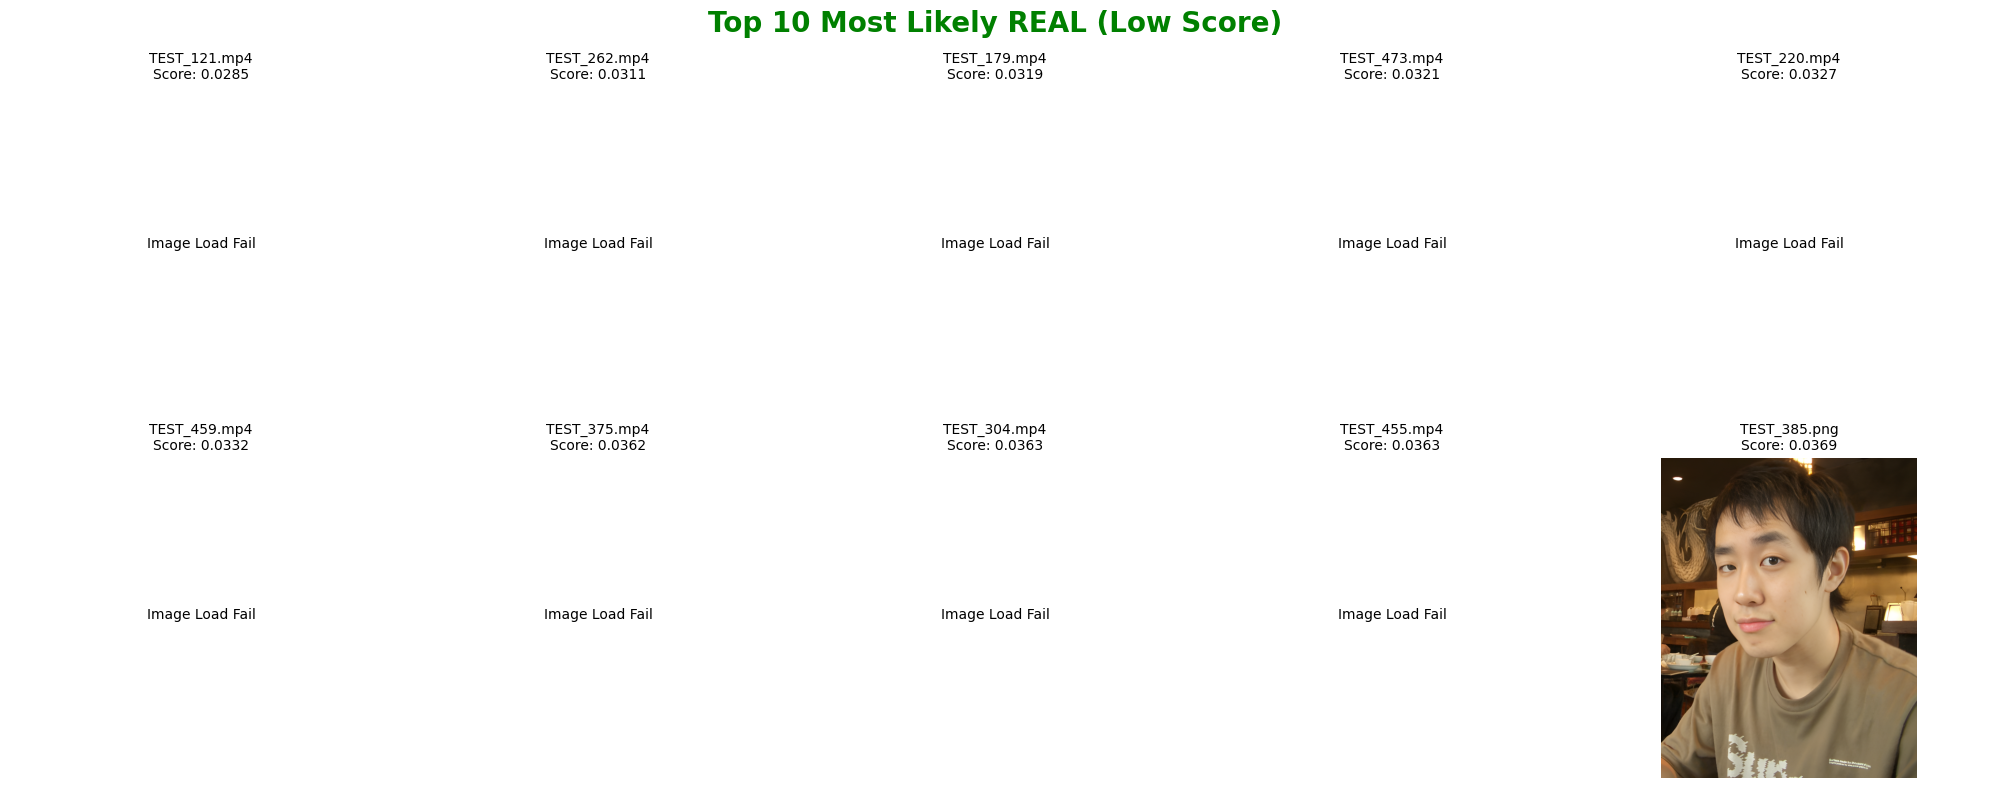


🔴 [Fake] 가짜일 확률이 높은 (점수가 높은) 상위 10개


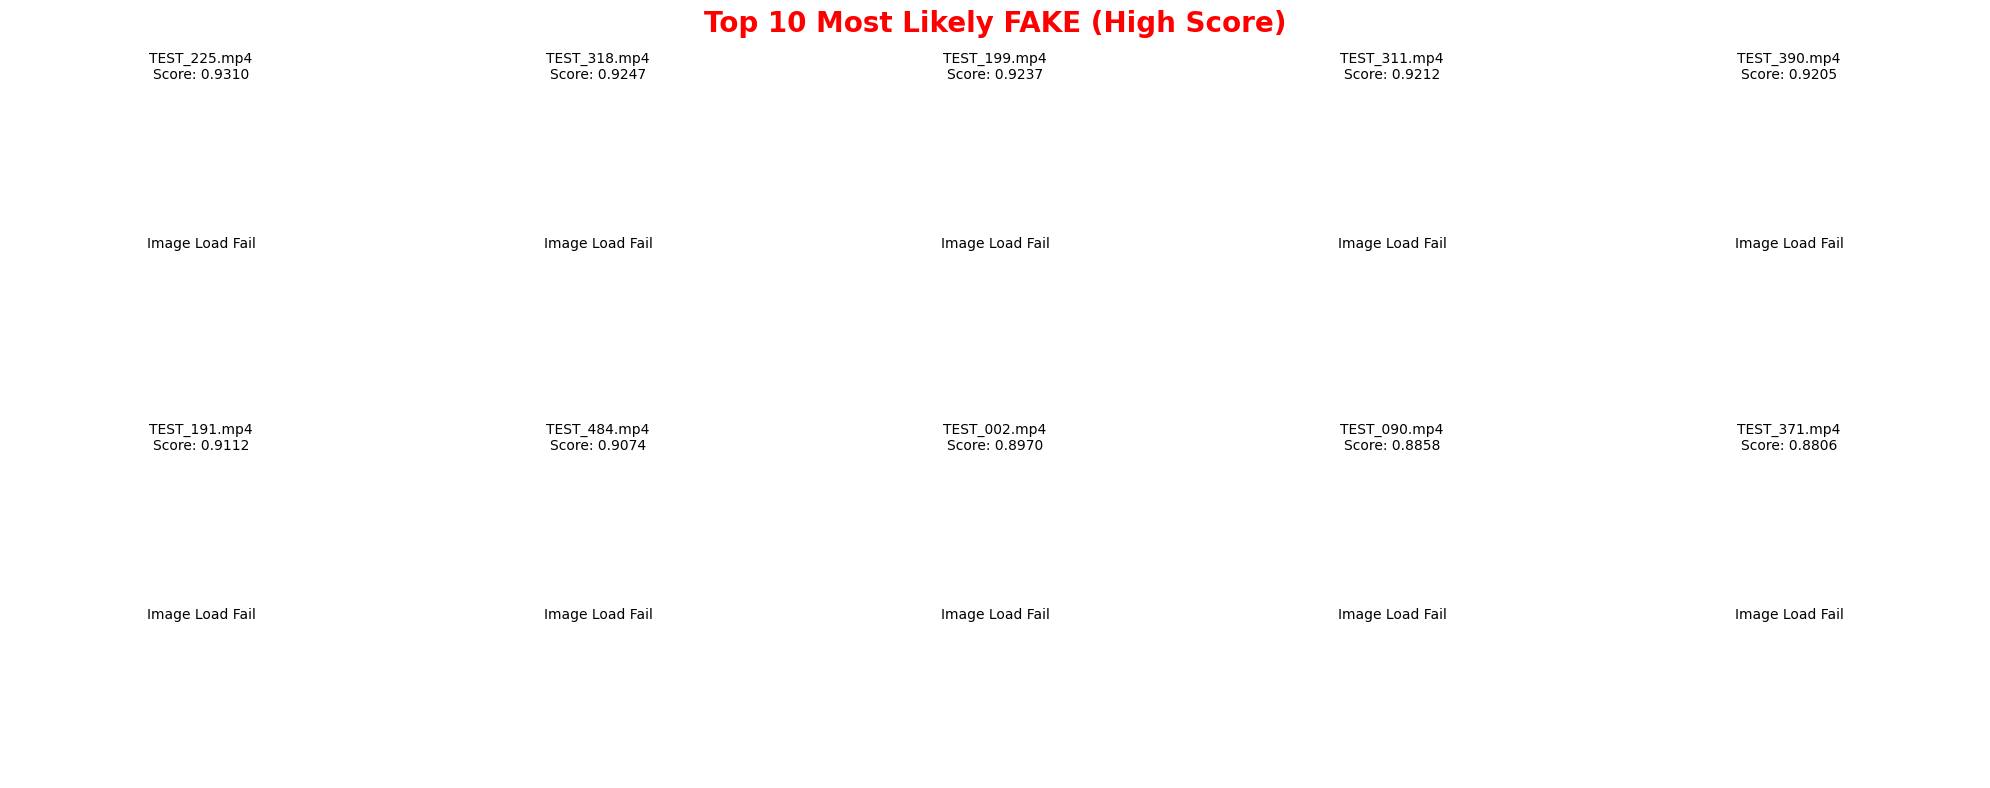

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

# ==========================================
# 사용자 설정 (이 부분을 본인 상황에 맞게 수정하세요)
csv_path = 'submission.csv'   # 추론 결과 CSV 파일 경로
image_folder = './test_data'  # 이미지가 들어있는 폴더
id_col = 'filename'               # CSV에서 파일명이 적힌 컬럼 이름 (예: id, path, filename 등)
label_col = 'prob'           # CSV에서 확률/점수가 적힌 컬럼 이름 (예: label, pred, score 등)
# ==========================================

def visualize_top_images(df, sort_ascending, title, color):
    """
    df: 데이터프레임
    sort_ascending: True면 낮은 점수(Real 추정), False면 높은 점수(Fake 추정)
    title: 그래프 제목
    """
    # 정렬하여 상위 10개 추출
    top_10 = df.sort_values(by=label_col, ascending=sort_ascending).head(10)

    plt.figure(figsize=(20, 8))
    plt.suptitle(title, fontsize=20, color=color, weight='bold')

    for idx, (i, row) in enumerate(top_10.iterrows()):
        file_name = row[id_col]
        score = row[label_col]

        # 이미지 경로 결합 (CSV에 전체 경로가 있는지, 파일명만 있는지에 따라 다름)
        # 만약 CSV에 'test_data/abc.jpg' 처럼 폴더명까지 있다면 os.path.basename 사용 필요
        full_path = os.path.join(image_folder, os.path.basename(file_name))

        plt.subplot(2, 5, idx + 1)

        if os.path.exists(full_path):
            # 한글 경로 등이 있을 수 있으므로 opencv 대신 matplotlib image read 사용 권장될 수 있으나
            # 여기서는 cv2로 읽고 색상 변환
            img = cv2.imread(full_path)
            if img is None:
                plt.text(0.5, 0.5, 'Image Load Fail', ha='center')
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                plt.imshow(img)
        else:
            plt.text(0.5, 0.5, 'File Not Found', ha='center')

        plt.title(f"{os.path.basename(file_name)}\nScore: {score:.4f}", fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 1. CSV 로드
if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
    print(f"📄 CSV 로드 완료: {len(df)}행")

    # 2. 진짜 같은 사진 (점수가 낮은 순, 0에 가까움)
    print("\n🟢 [Real] 진짜일 확률이 높은 (점수가 낮은) 상위 10개")
    visualize_top_images(df, sort_ascending=True, title="Top 10 Most Likely REAL (Low Score)", color='green')

    # 3. 가짜 같은 사진 (점수가 높은 순, 1에 가까움)
    print("\n🔴 [Fake] 가짜일 확률이 높은 (점수가 높은) 상위 10개")
    visualize_top_images(df, sort_ascending=False, title="Top 10 Most Likely FAKE (High Score)", color='red')

else:
    print(f"❌ CSV 파일을 찾을 수 없습니다: {csv_path}")
    print("추론(Inference) 코드를 먼저 실행하여 CSV 파일을 만들어주세요.")